<a href="https://colab.research.google.com/github/LuisJavierFI/Departamento-de-Ventas/blob/main/3_Ventas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Departamento de Ventas


# Objetivos
* Desarrollar un modelo predictivo
* Predicción de ventas futuras usando series temporales
* Forecast con Facebook Prophet
* Analizar tendencias

In [1]:
%%capture
!pip install fbprophet

In [3]:
import prophet
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

import warnings
warnings.simplefilter("ignore")

# Dataset de Ventas

https://www.kaggle.com/c/rossmann-store-sales/data

In [4]:
# Debes incluir el enlace completo al archivo csv que contiene tu conjunto de datos
sales_train_df = pd.read_csv("https://raw.githubusercontent.com/LuisJavierFI/Departamento-de-Ventas/main/train.csv")

In [5]:
sales_train_df.head(5)
# Casi un millón de observaciones
# 1115 tiendas únicas
# Notemos que las ventas es la variable objetivo (la que intentamos predecir)

# Id:  ID de transacción (combinación de la tienda y la fecha)
# Store: identificador único de la tienda
# Sales: ventas diarias, esta es la variable objetivo
# Customers: número de clientes de un día dado
# Open: Booleano para indicar si la tienda estaba abierta o cerrada (0 = cerrada, 1 = abierta)
# Promo: describe si la tienda tenía algún tipo de promoción ese día o no
# StateHoliday: indica si el día era festivo o no (a = vacaciones públicas, b = vacaciones de Pascua holiday, c = Navidades, 0 = No era festivo)
# SchoolHoliday: indica si (Store, Date) se ve afectado por el cierre de las escuelas públicas

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [6]:
sales_train_df.tail(10)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1017199,1106,2,2013-01-01,0,0,0,0,a,1
1017200,1107,2,2013-01-01,0,0,0,0,a,1
1017201,1108,2,2013-01-01,0,0,0,0,a,1
1017202,1109,2,2013-01-01,0,0,0,0,a,1
1017203,1110,2,2013-01-01,0,0,0,0,a,1
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1
1017208,1115,2,2013-01-01,0,0,0,0,a,1


In [7]:
sales_train_df.info()
# 9 columnas en total
# 8 características, cada una con 1017209 puntos de datos
# 1 variable objetivo (ventas)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [8]:
sales_train_df.describe()
# Cantidad de ventas promedio por día = 5773 Euros, ventas mínimas por día = 0, ventas máximas por día = 41551
# Número medio de clientes = 633, número mínimo de clientes = 0, número máximo de clientes = 7388

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


# Dataset de la tiendas




In [9]:
store_info_df = pd.read_csv("https://raw.githubusercontent.com/LuisJavierFI/Departamento-de-Ventas/main/store.csv")
# StoreType: categoría que indica el tipo de tienda (a, b, c, d)
# Assortment:  a = básico, b = extra, c = extedido
# CompetitionDistance (en metros): distancia a la tienda de la competencia más cercana
# CompetitionOpenSince [Mes/Año]:  fecha en que abrió la competencia
# Promo2: Promo2 es una promoción continuada y consecutiva en algunas tiendas (0 = la tienda no participa, 1 = la tienda participa)
# Promo2Since [Año/Semana]: fecha en la que la tienda empieza a participar en la Promo2
# PromoInterval: describe los intervalos consecutivos donde la Promo2 empieza, indicando los meses en los que empieza la misma. P.e. "Feb,May,Aug,Nov" significa que cada nueva ronda de promoción empieza en Febrero, Mayo, Agosto, Noviembre de cualquier año de esa tienda


In [10]:
store_info_df.head(5)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [11]:
# Hay que tener en cuenta que el data frame anterior incluye las transacciones registradas por día (en millones)
# Este data frame solo incluye información sobre las 1115 tiendas exclusivas que forman parte de este estudio
store_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [12]:
# De media, la distancia de la competencia es de 5404 metros (5,4 kms)
store_info_df.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


# Datos faltantes

<Axes: >

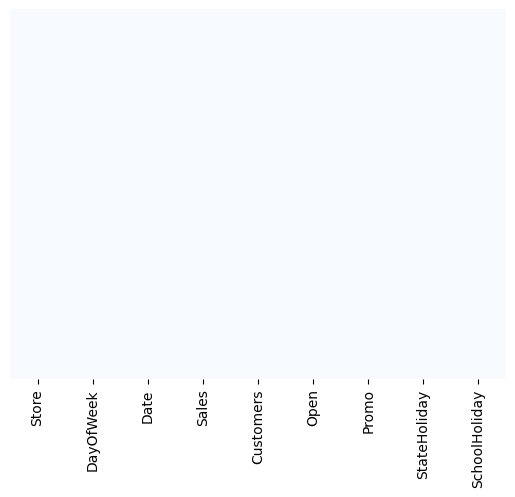

In [13]:
sns.heatmap(sales_train_df.isnull(), yticklabels=False, cbar = False, cmap = "Blues")

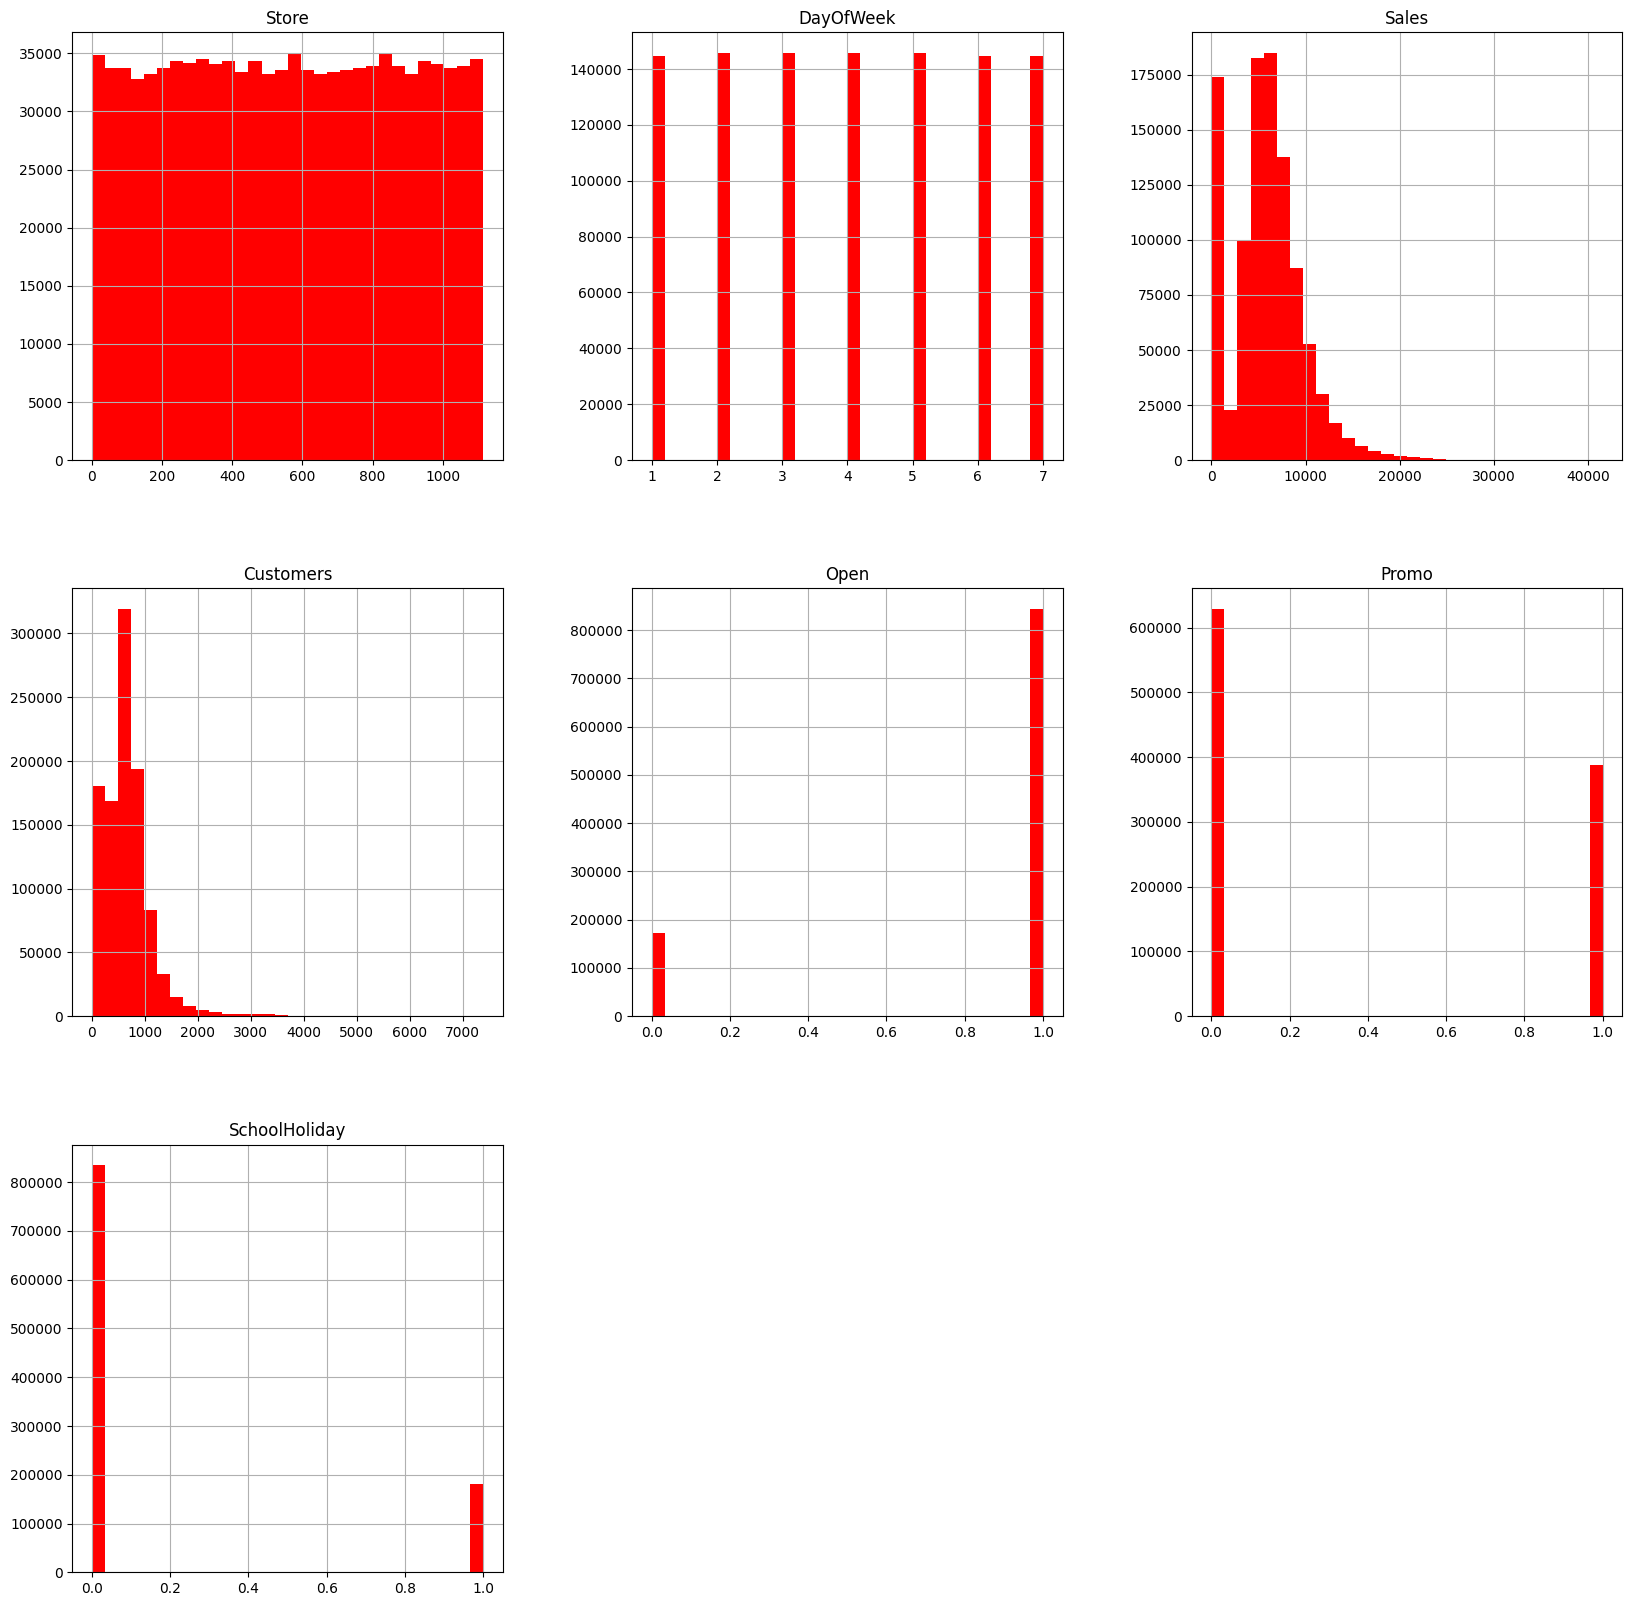

In [15]:
# Promedio de 600 clientes por día, el máximo es 4500 (¡tenga en cuenta que no podemos ver el valor atípico en 7388!)
# Los datos se distribuyen por igual en varios días de la semana (~ 150000 observaciones x 7 días = ~ 1,1 millones de observaciones)
# Las tiendas están abiertas ~ 80% del tiempo
# Los datos se distribuyen por igual entre todas las tiendas (sin sesgo)
# La promoción # 1 se ejecutó aproximadamente el 40% del tiempo
# Ventas promedio alrededor de 5000-6000 Euros
# Las vacaciones escolares duran alrededor del 18% del tiempo
sales_train_df.hist(bins = 30, figsize=(20,20), color = 'r')
plt.show()

In [16]:
sales_train_df["Customers"].max()

7388

In [17]:
# Tiendas están abiertas y cerradas
closed_train_df = sales_train_df[sales_train_df['Open'] == 0]
open_train_df   = sales_train_df[sales_train_df['Open'] == 1]

In [18]:
# Número de tiendas que están abiertas y cerradas
print("Total = {} ".format(len(sales_train_df)))
print("Número de tiendas abiertas = {}".format(len(open_train_df)))
print("Número de tiendas cerradas = {}".format(len(closed_train_df)))
print("Porcentaje de tiendas cerradas = {}%".format(100.0*len(closed_train_df)/len(sales_train_df)))

Total = 1017209 
Número de tiendas abiertas = 844392
Número de tiendas cerradas = 172817
Porcentaje de tiendas cerradas = 16.98933060954042%


In [19]:
# nos quedamos solo con las tiendas abiertas y eliminamos las tiendas cerradas
sales_train_df = sales_train_df[sales_train_df['Open'] == 1]

In [20]:
sales_train_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,566,1,0,a,1
1016827,733,2,2013-01-01,10765,2377,1,0,a,1
1016863,769,2,2013-01-01,5035,1248,1,0,a,1
1017042,948,2,2013-01-01,4491,1039,1,0,a,1


In [21]:
# Eliminemos la columna open ya que ahora no tiene sentido
sales_train_df.drop(['Open'], axis = 1, inplace = True)

In [22]:
sales_train_df

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,0,1
1,2,5,2015-07-31,6064,625,1,0,1
2,3,5,2015-07-31,8314,821,1,0,1
3,4,5,2015-07-31,13995,1498,1,0,1
4,5,5,2015-07-31,4822,559,1,0,1
...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,566,0,a,1
1016827,733,2,2013-01-01,10765,2377,0,a,1
1016863,769,2,2013-01-01,5035,1248,0,a,1
1017042,948,2,2013-01-01,4491,1039,0,a,1


In [23]:
# Ventas promedio = 6955 Euros, número promedio de clientes = 762 (ha subido)
sales_train_df.describe()

,Store,DayOfWeek,Sales,Customers,Promo,SchoolHoliday
count,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000
mean,558.422920,3.520361,6955.514291,762.728395,0.446352,0.193580
std,321.731914,1.723689,3104.214680,401.227674,0.497114,0.395103
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,280.000000,2.000000,4859.000000,519.000000,0.000000,0.000000
50%,558.000000,3.000000,6369.000000,676.000000,0.000000,0.000000
75%,837.000000,5.000000,8360.000000,893.000000,1.000000,0.000000
max,1115.000000,7.000000,41551.000000,7388.000000,1.000000,1.000000


#Datos Faltantes de las tiendas

<Axes: >

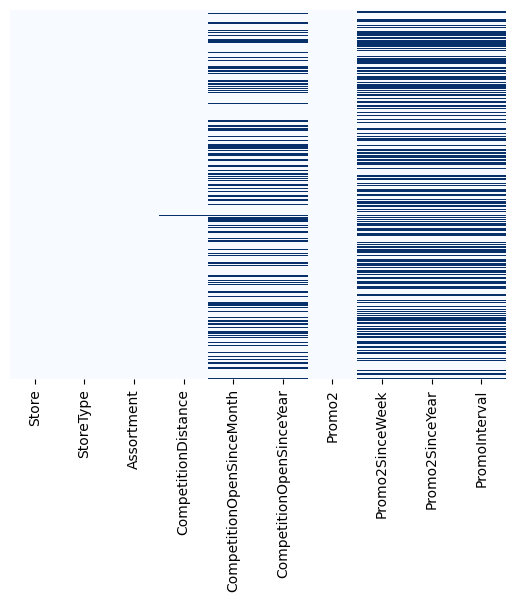

In [24]:
sns.heatmap(store_info_df.isnull(), yticklabels=False, cbar=False, cmap = "Blues")

In [25]:
# Echemos un vistazo a los valores faltantes en la 'CompetitionDistance'
# Solo faltan 3 filas
store_info_df[store_info_df['CompetitionDistance'].isnull()]


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [26]:
# Echemos un vistazo a los valores faltantes en el 'CompetitionOpenSinceMonth'
# Faltan muchas filas = 354 (casi un tercio de las 1115 tiendas)
store_info_df[store_info_df['CompetitionOpenSinceMonth'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...
1095,1096,a,c,1130.0,NaN,NaN,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
1099,1100,a,a,540.0,NaN,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [27]:
store_info_df[store_info_df['Promo2'] == 0]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1107,1108,a,a,540.0,4.0,2004.0,0,NaN,NaN,NaN
1109,1110,c,c,900.0,9.0,2010.0,0,NaN,NaN,NaN
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN


In [28]:
# Parece que si 'promo2' es cero, 'promo2SinceWeek', 'Promo2SinceYear' y la información de 'PromoInterval' se establece en cero
# Hay 354 filas donde 'CompetitionOpenSinceYear' y 'CompetitionOpenSinceMonth' falta
# Establezcamos estos valores en ceros
str_cols = ['Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth']

for str in str_cols:
    store_info_df[str].fillna(0, inplace = True)

<Axes: >

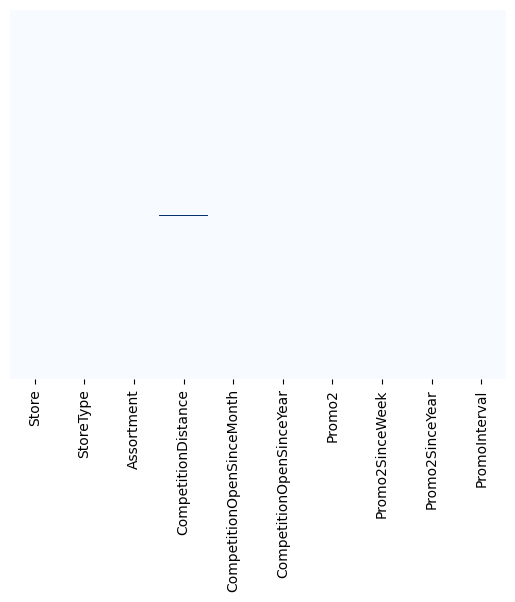

In [29]:
sns.heatmap(store_info_df.isnull(), yticklabels=False, cbar=False, cmap = "Blues")

In [30]:
# Hay 3 filas con valores de 'CompetitionDistance' que faltan, llenémoslas con valores promedio de la columna 'CompetitionDistance'
store_info_df['CompetitionDistance'].fillna(store_info_df['CompetitionDistance'].mean(), inplace=True)

<Axes: >

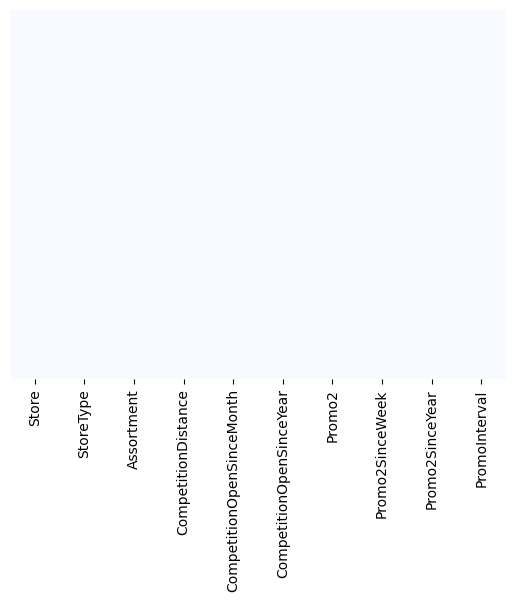

In [31]:
sns.heatmap(store_info_df.isnull(), yticklabels=False, cbar=False, cmap = "Blues")

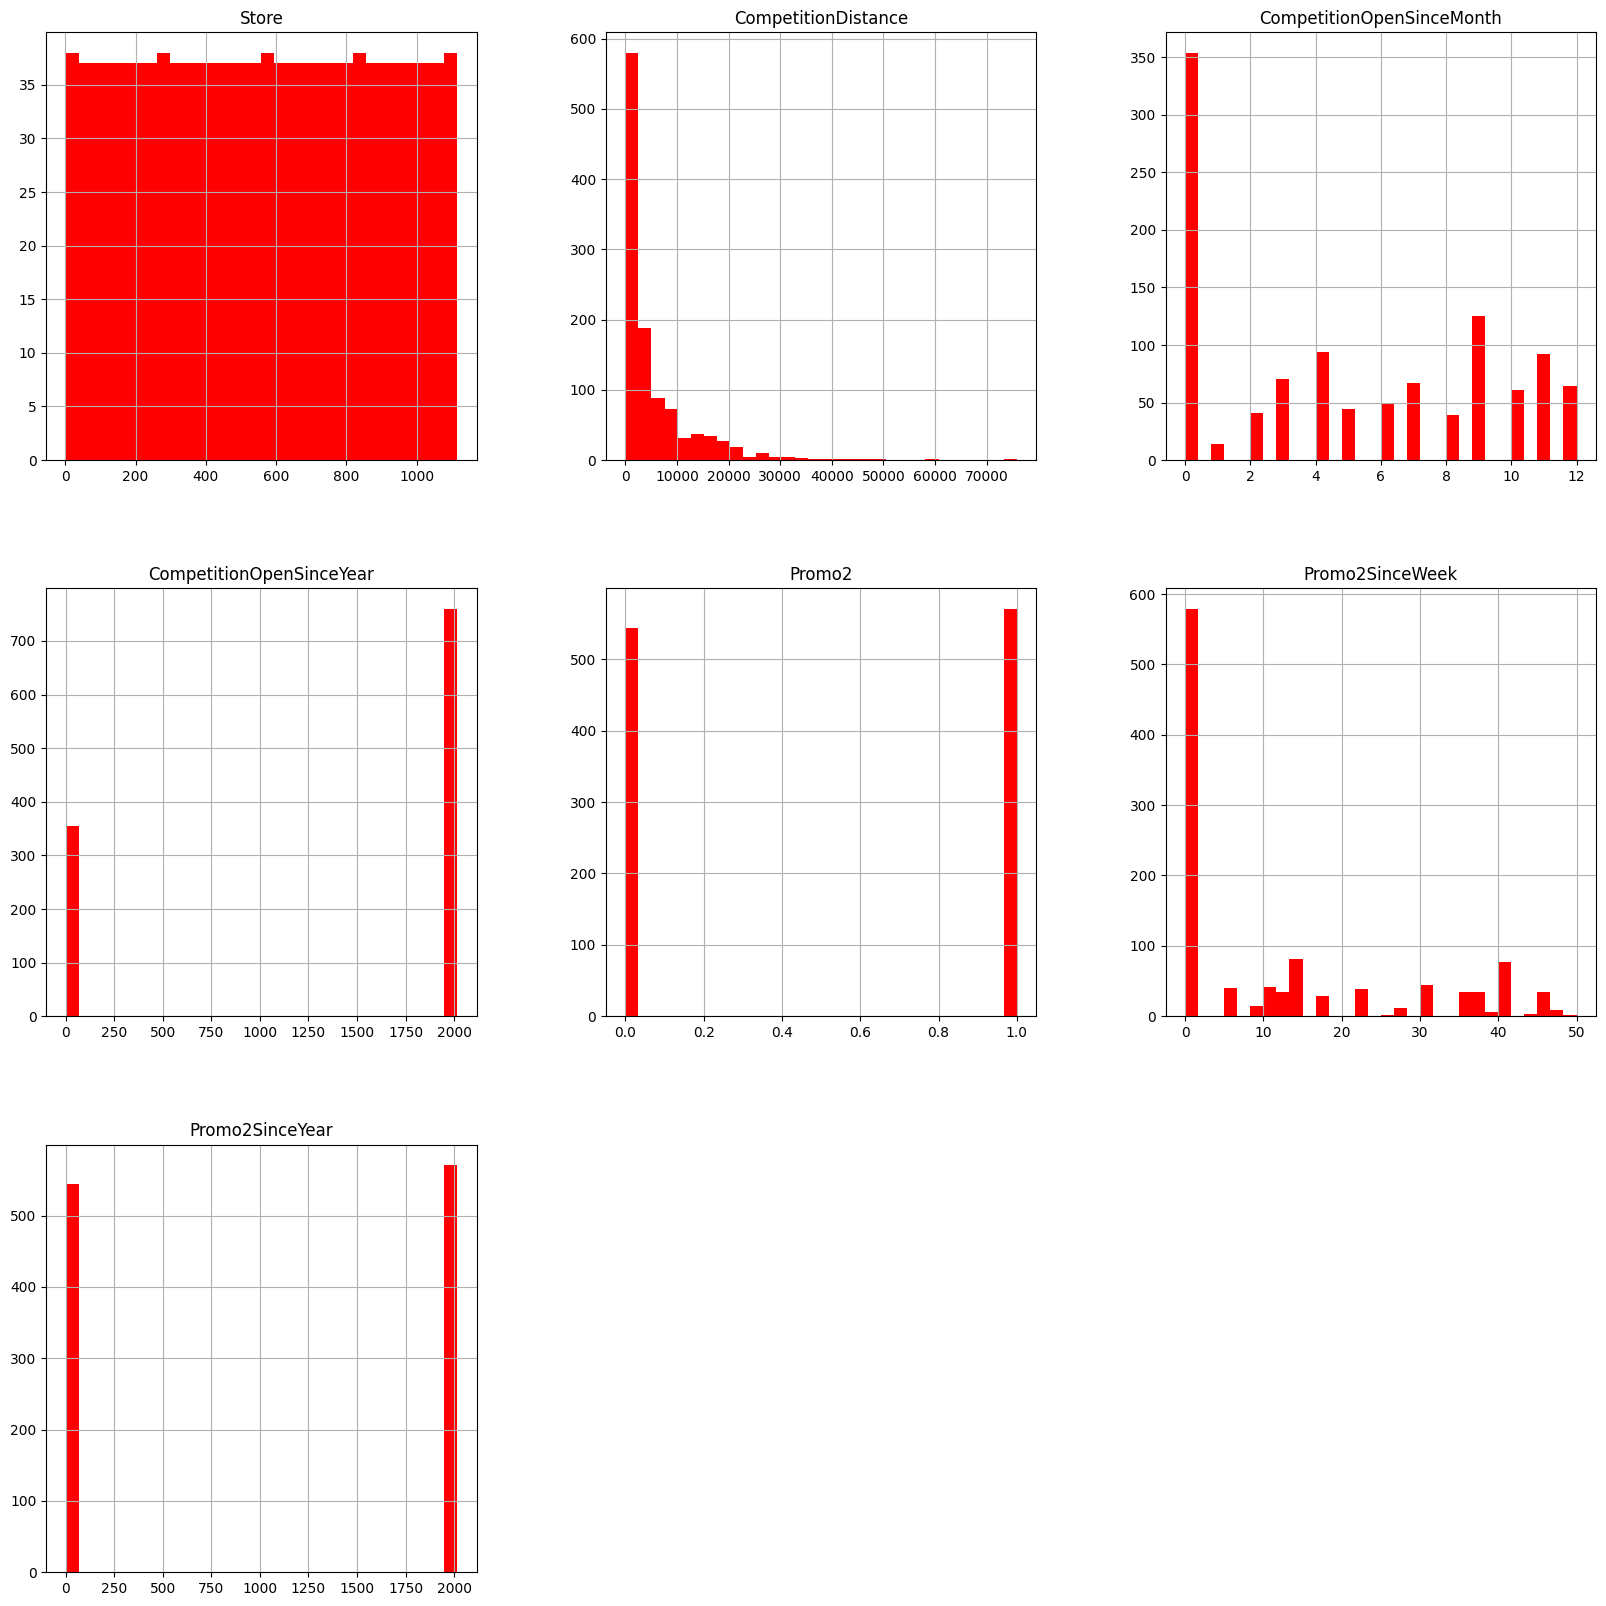

In [33]:
# la mitad de las tiendas participan en la promoción 2
# la mitad de las tiendas tienen su competencia a una distancia de 0-3000 m (3 kms de distancia)
store_info_df.hist(bins = 30, figsize=(20,20), color = 'r')
plt.show()

# Juntar dataframes

In [34]:
# Combinemos ambos data frames en función de 'store'
# Combinemos ambos data frames en función de 'store'
sales_train_all_df = pd.merge(sales_train_df, store_info_df, how = 'inner', on = 'Store')

In [ ]:
# exportar el dataframe
# sales_train_all_df.to_csv('test.csv', index = False)

In [35]:
sales_train_all_df

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,2015-07-30,5020,546,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,2015-07-29,4782,523,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,2015-07-28,5011,560,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,2015-07-27,6102,612,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844387,292,1,2013-01-07,9291,1002,1,0,0,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0
844388,292,6,2013-01-05,2748,340,0,0,0,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0
844389,292,5,2013-01-04,4202,560,0,0,1,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0
844390,292,4,2013-01-03,4580,662,0,0,1,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0


In [36]:
correlations = sales_train_all_df.corr()['Sales'].sort_values()
correlations
# los clientes y la promoción se correlacionan positivamente con las ventas
# Promo2 no parece ser efectivo en absoluto

DayOfWeek                   -0.178736
Promo2SinceYear             -0.127621
Promo2                      -0.127596
Promo2SinceWeek             -0.058476
CompetitionDistance         -0.036343
CompetitionOpenSinceMonth   -0.018370
CompetitionOpenSinceYear     0.005266
Store                        0.007710
SchoolHoliday                0.038617
Promo                        0.368145
Customers                    0.823597
Sales                        1.000000
Name: Sales, dtype: float64

<Axes: >

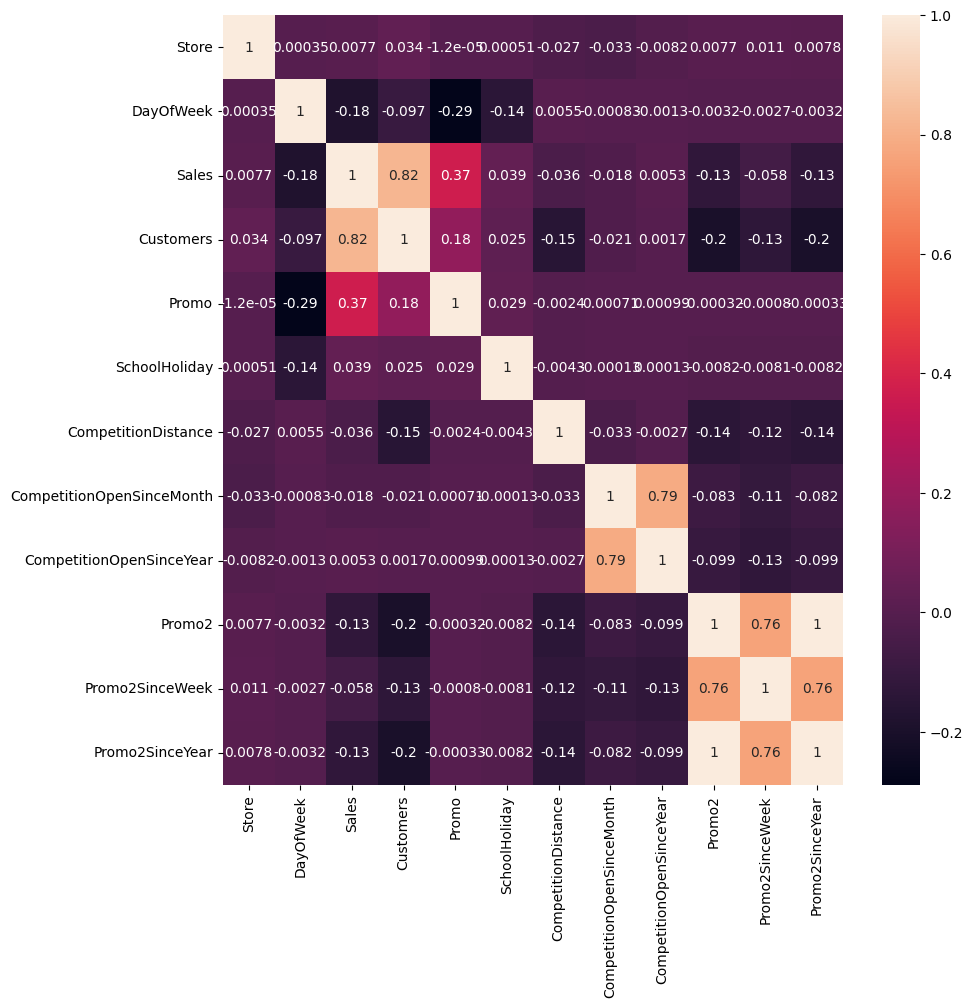

In [37]:
correlations = sales_train_all_df.corr()
f, ax = plt.subplots(figsize = (10,10))
sns.heatmap(correlations, annot=True)
# Los clientes / Promo2 y las ventas están fuertemente correlacionados

In [39]:
# Separar el año y ponerlo en una columna separada
sales_train_all_df['Year'] = pd.DatetimeIndex(sales_train_all_df['Date']).year

In [40]:
# Repetir lo mismo para el día y el mes
sales_train_all_df['Month'] = pd.DatetimeIndex(sales_train_all_df['Date']).month
sales_train_all_df['Day'] = pd.DatetimeIndex(sales_train_all_df['Date']).day

In [41]:
sales_train_all_df

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day
0,1,5,2015-07-31,5263,555,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,31
1,1,4,2015-07-30,5020,546,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,30
2,1,3,2015-07-29,4782,523,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,29
3,1,2,2015-07-28,5011,560,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,28
4,1,1,2015-07-27,6102,612,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844387,292,1,2013-01-07,9291,1002,1,0,0,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0,2013,1,7
844388,292,6,2013-01-05,2748,340,0,0,0,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0,2013,1,5
844389,292,5,2013-01-04,4202,560,0,0,1,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0,2013,1,4
844390,292,4,2013-01-03,4580,662,0,0,1,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0,2013,1,3


Text(0.5, 1.0, 'Clientes promedio por Mes')

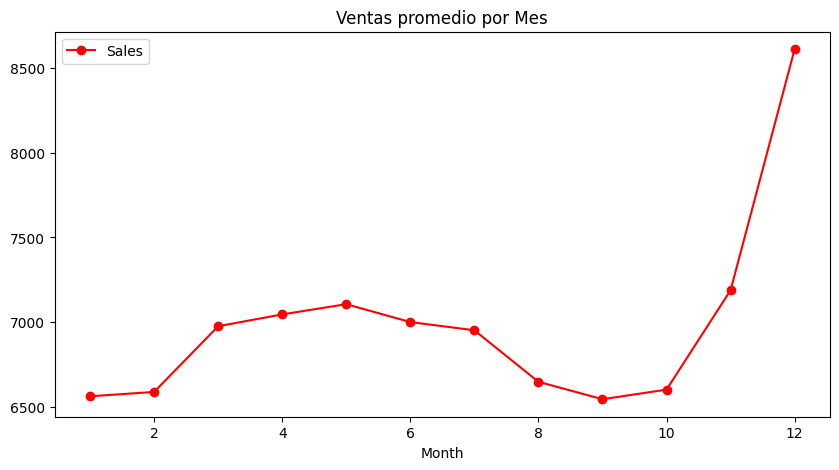

<Figure size 640x480 with 0 Axes>

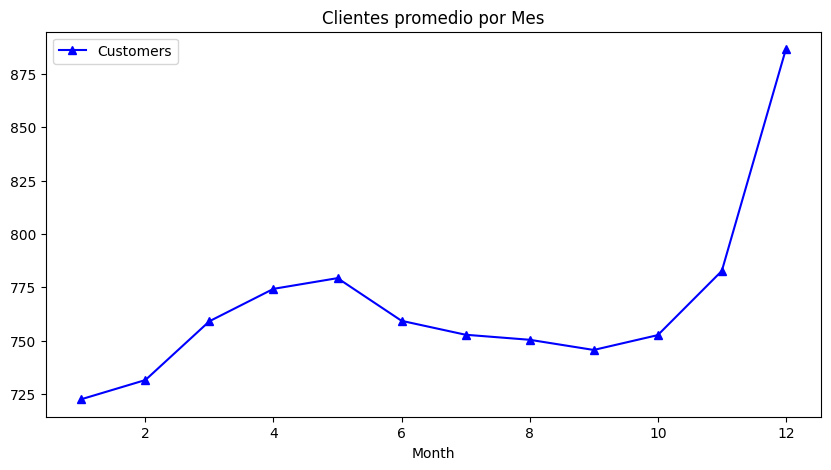

In [42]:
# Echemos un vistazo a las ventas promedio y la cantidad de clientes por mes.
# 'groupby' funciona muy bien al agrupar todos los datos que comparten la misma columna del mes, luego obtener la media de la columna de ventas
# Parece que las ventas y el número de clientes alcanzan su punto máximo en el período de Navidad
axis = sales_train_all_df.groupby('Month')[['Sales']].mean().plot(figsize = (10, 5), marker = 'o', color = 'r')
axis.set_title("Ventas promedio por Mes")


plt.figure()
axis = sales_train_all_df.groupby('Month')[['Customers']].mean().plot(figsize = (10, 5), marker = '^', color = 'b')
axis.set_title("Clientes promedio por Mes")

Text(0.5, 1.0, 'Clientes promedio por Dia')

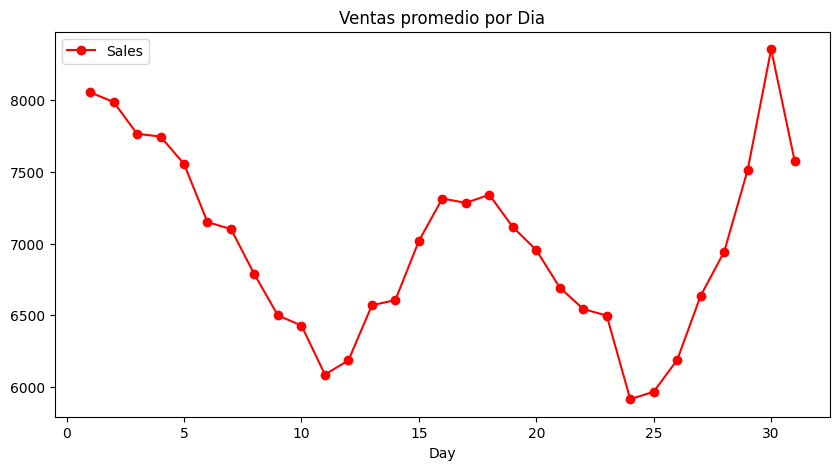

<Figure size 640x480 with 0 Axes>

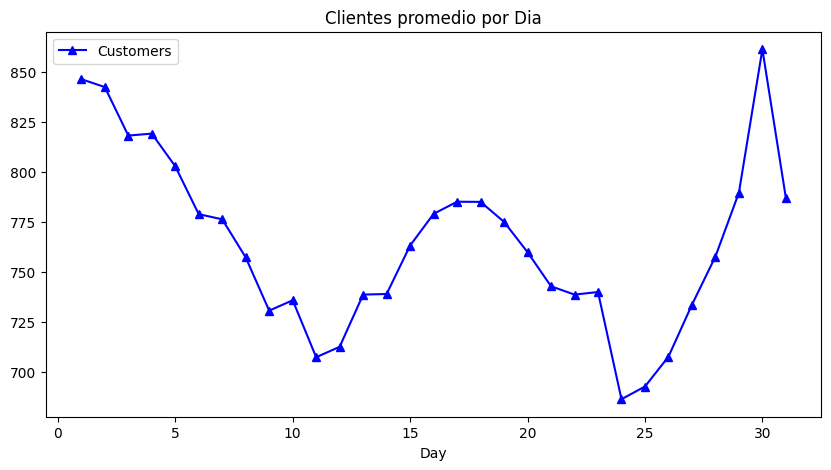

In [43]:
# Echemos un vistazo a las ventas y a los clientes por día del mes.
# El número mínimo de clientes suele rondar el día 24 del mes.
# La mayoría de los clientes y las ventas son alrededor del 30 y el 1 del mes
axis = sales_train_all_df.groupby('Day')[['Sales']].mean().plot(figsize = (10, 5), marker = 'o', color = 'r')
axis.set_title("Ventas promedio por Dia")


plt.figure()
axis = sales_train_all_df.groupby('Day')[['Customers']].mean().plot(figsize = (10, 5), marker = '^', color = 'b')
axis.set_title("Clientes promedio por Dia")

Text(0.5, 1.0, 'Clientes promedio por dia de la semana')

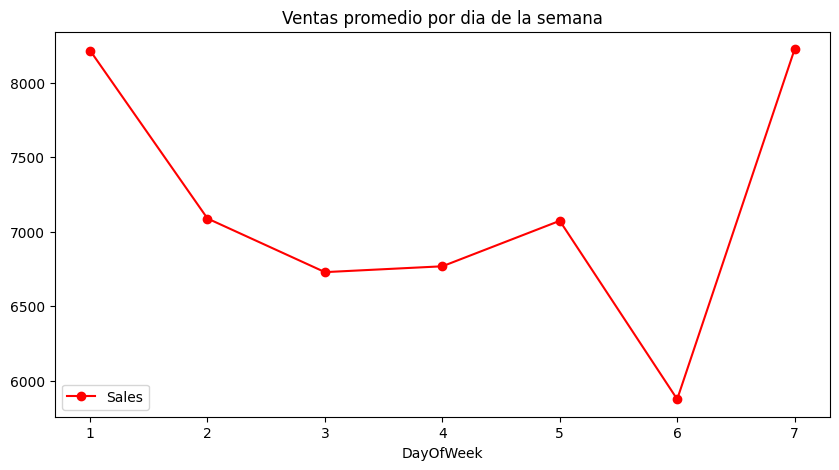

<Figure size 640x480 with 0 Axes>

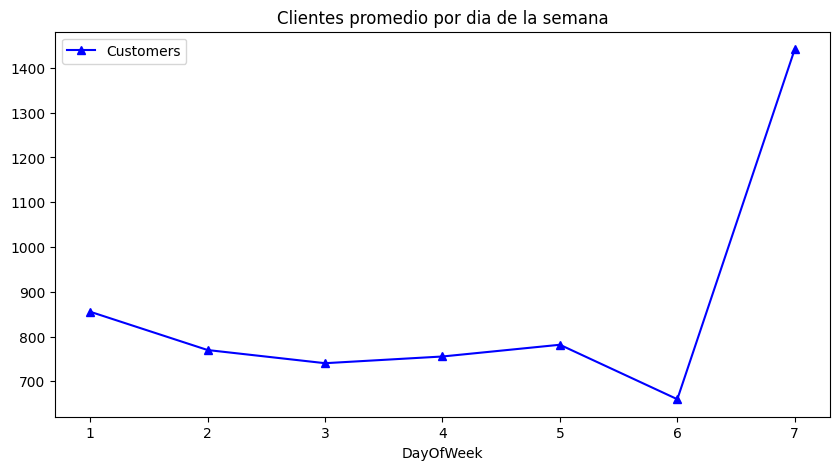

In [44]:
# Hagamos lo mismo para el día de la semana (notemos que 7 = domingo)
axis = sales_train_all_df.groupby('DayOfWeek')[['Sales']].mean().plot(figsize = (10, 5), marker = 'o', color = 'r')
axis.set_title("Ventas promedio por dia de la semana")


plt.figure()
axis = sales_train_all_df.groupby('DayOfWeek')[['Customers']].mean().plot(figsize = (10, 5), marker = '^', color = 'b')
axis.set_title("Clientes promedio por dia de la semana")

<Axes: xlabel='Date'>

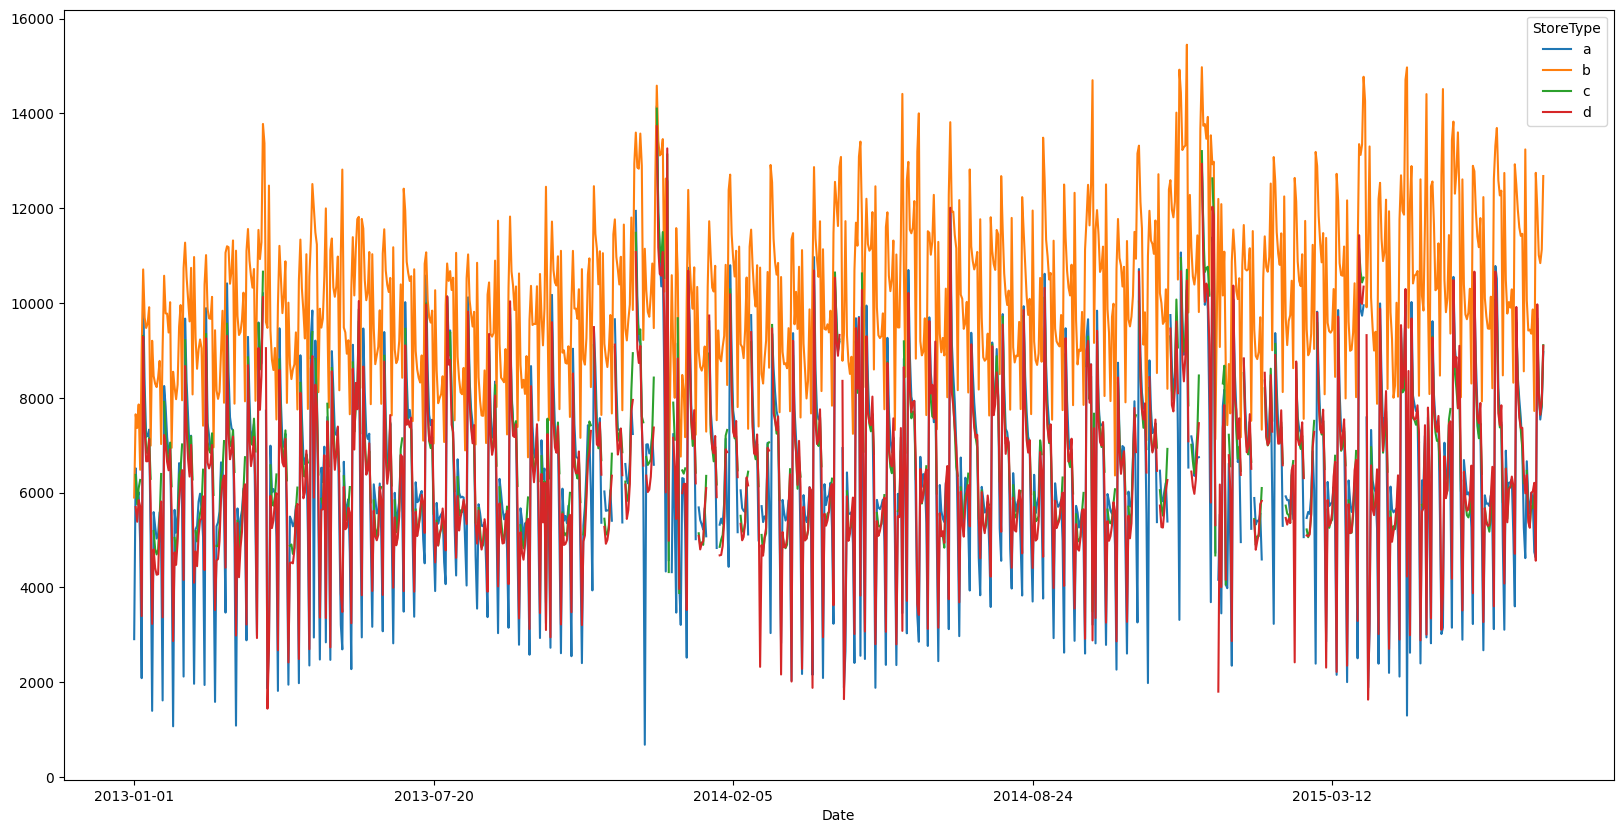

In [45]:
fig, ax = plt.subplots(figsize = (20, 10))
sales_train_all_df.groupby(['Date', 'StoreType']).mean()['Sales'].unstack().plot(ax = ax)

<Axes: xlabel='Promo', ylabel='Customers'>

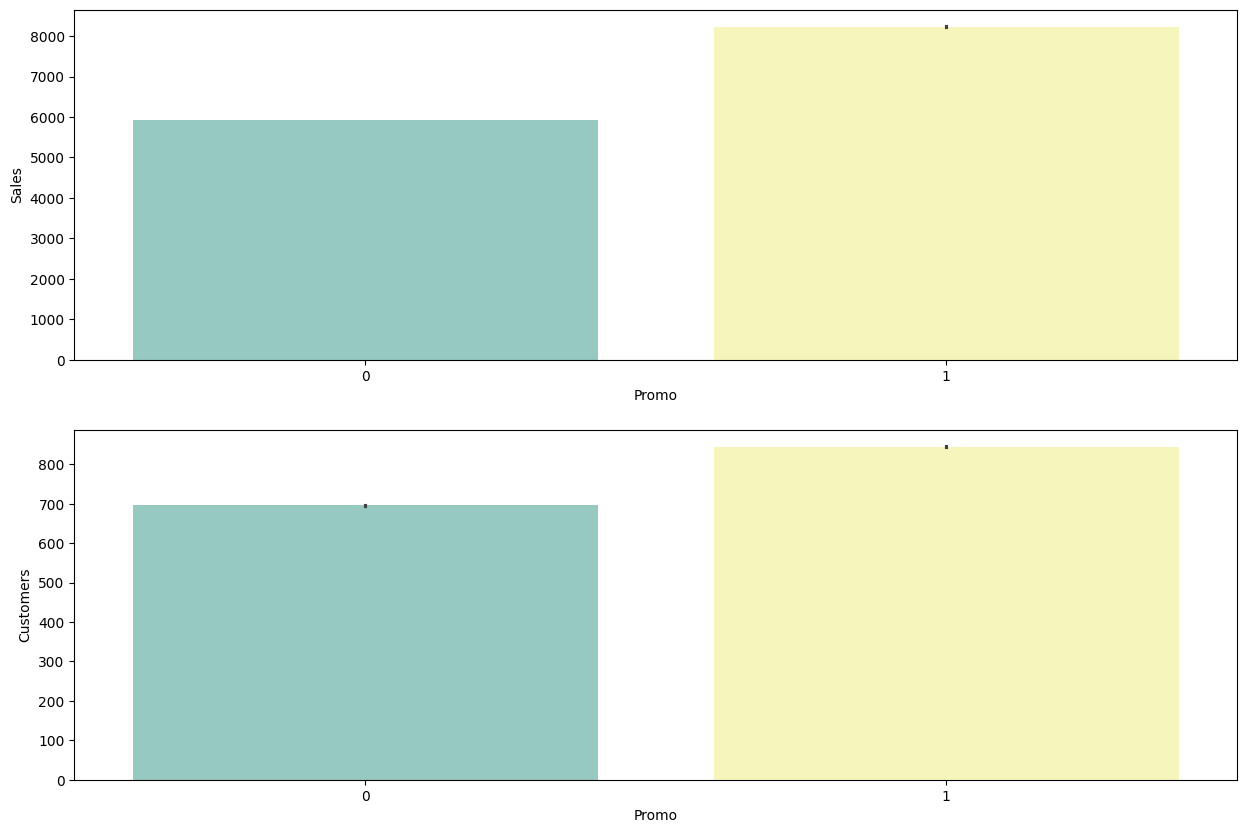

In [47]:
plt.figure(figsize=[15,10])

plt.subplot(211)
sns.barplot(x = 'Promo', y = 'Sales', data = sales_train_all_df,palette="Set3")

plt.subplot(212)
sns.barplot(x = 'Promo', y = 'Customers', data = sales_train_all_df,palette="Set3")

<Axes: xlabel='Promo', ylabel='Customers'>

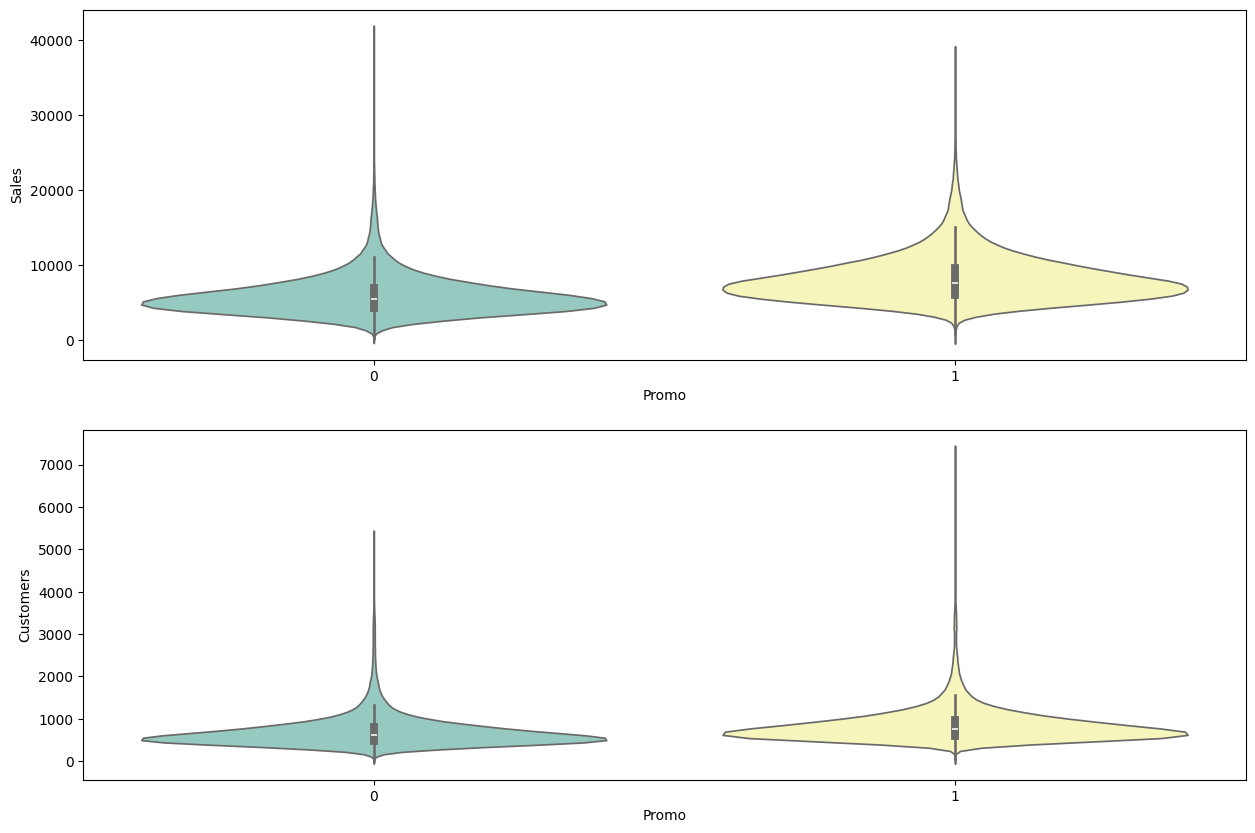

In [48]:
plt.figure(figsize=[15,10])

plt.subplot(211)
sns.violinplot(x = 'Promo', y = 'Sales', data = sales_train_all_df,palette="Set3")

plt.subplot(212)
sns.violinplot(x = 'Promo', y = 'Customers', data = sales_train_all_df,palette="Set3")

In [49]:
sales_train_all_df.shape

(844392, 20)

#  Facebook Prophet

# Entrenar el modelo

In [50]:
def sales_predictions(Store_ID, sales_df, periods):
    sales_df = sales_df[sales_df['Store'] == Store_ID]
    sales_df = sales_df[['Date', 'Sales']].rename(columns = {'Date': 'ds', 'Sales': 'y'})
    sales_df = sales_df.sort_values('ds')

    model = prophet.Prophet()
    model.fit(sales_df)
    future   = model.make_future_dataframe(periods = periods)
    forecast = model.predict(future)
    figure   = model.plot(forecast, xlabel = "Fecha", ylabel = "Ventas")
    figure2  = model.plot_components(forecast)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw9ddb31k/kd0bsyrx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw9ddb31k/i4lm9cmb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31324', 'data', 'file=/tmp/tmpw9ddb31k/kd0bsyrx.json', 'init=/tmp/tmpw9ddb31k/i4lm9cmb.json', 'output', 'file=/tmp/tmpw9ddb31k/prophet_modelp_dlirib/prophet_model-20240201215007.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:50:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:50:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


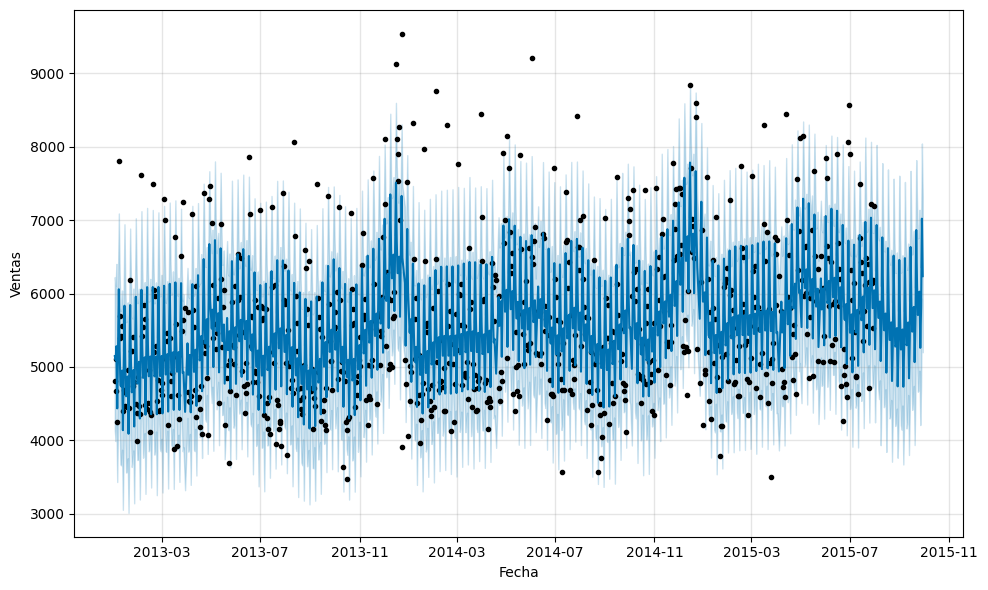

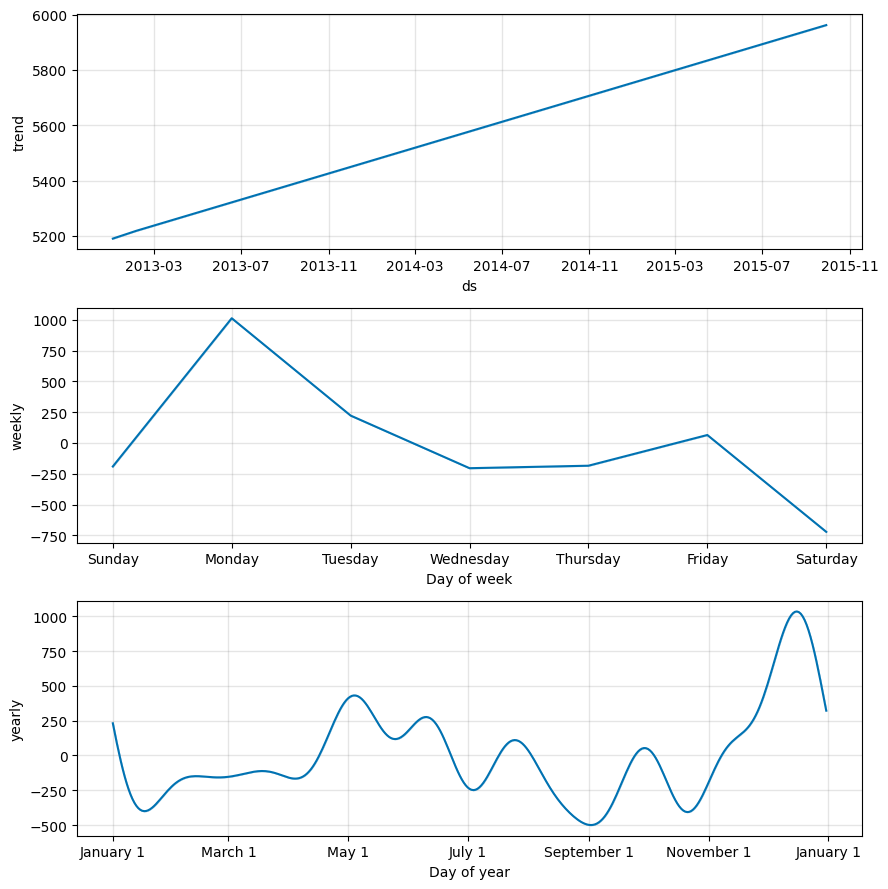

In [51]:
sales_predictions(10, sales_train_all_df, 60)

# Entrenar el modelo, tomando vacaciones

- StateHoliday: indica si el día era festivo o no (a = vacaciones públicas, b = vacaciones de Pascua holiday, c = Navidades, 0 = No era festivo)
- SchoolHoliday: indica si (Store, Date) se ve afectado por el cierre de las escuelas públicas
  






In [52]:
def sales_predictions(Store_ID, sales_df, holidays, periods):
    sales_df = sales_df[sales_df['Store'] == Store_ID]
    sales_df = sales_df[['Date', 'Sales']].rename(columns = {'Date': 'ds', 'Sales': 'y'})
    sales_df = sales_df.sort_values('ds')

    model = prophet.Prophet(holidays=holidays)
    model.fit(sales_df)
    future   = model.make_future_dataframe(periods = periods)
    forecast = model.predict(future)
    figure   = model.plot(forecast, xlabel = "Fecha", ylabel = "Ventas")
    figure2  = model.plot_components(forecast)


In [53]:
# Obtener todas las fechas relacionadas con las vacaciones escolares
school_holidays = sales_train_all_df[sales_train_all_df['SchoolHoliday']==1].loc[:,'Date'].values
school_holidays.shape

(163457,)

In [54]:
school_holidays = np.unique(school_holidays)
school_holidays.shape

(477,)

In [55]:
# Obtener todas las fechas correspondientes a los festivos estatales
state_holidays = sales_train_all_df[(sales_train_all_df['StateHoliday'] == 'a') | (sales_train_all_df['StateHoliday'] == 'b') | (sales_train_all_df['StateHoliday'] == 'c')].loc[:, 'Date'].values
state_holidays.shape

(910,)

In [56]:
state_holidays = np.unique(state_holidays)
state_holidays.shape

(35,)

In [57]:
school_holidays = pd.DataFrame({'ds': pd.to_datetime(school_holidays),
                                'holiday': 'school_holiday'})

In [58]:
school_holidays

,ds,holiday
0,2013-01-01,school_holiday
1,2013-01-02,school_holiday
2,2013-01-03,school_holiday
3,2013-01-04,school_holiday
4,2013-01-05,school_holiday
...,...,...
472,2015-07-27,school_holiday
473,2015-07-28,school_holiday
474,2015-07-29,school_holiday
475,2015-07-30,school_holiday


In [59]:
state_holidays = pd.DataFrame({'ds': pd.to_datetime(state_holidays),
                                'holiday': 'state_holiday'})

In [60]:
state_holidays

,ds,holiday
0,2013-01-01,state_holiday
1,2013-01-06,state_holiday
2,2013-03-29,state_holiday
3,2013-04-01,state_holiday
4,2013-05-01,state_holiday
5,2013-05-09,state_holiday
6,2013-05-20,state_holiday
7,2013-05-30,state_holiday
8,2013-08-15,state_holiday
9,2013-10-03,state_holiday


In [61]:
# Concatenamos las vacaciones escolares y los festivos estatales
school_state_holidays = pd.concat((state_holidays, school_holidays), axis = 0)

In [62]:
school_state_holidays

,ds,holiday
0,2013-01-01,state_holiday
1,2013-01-06,state_holiday
2,2013-03-29,state_holiday
3,2013-04-01,state_holiday
4,2013-05-01,state_holiday
...,...,...
472,2015-07-27,school_holiday
473,2015-07-28,school_holiday
474,2015-07-29,school_holiday
475,2015-07-30,school_holiday


In [63]:
school_state_holidays.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 512 entries, 0 to 476
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   ds       512 non-null    datetime64[ns]
 1   holiday  512 non-null    object        
dtypes: datetime64[ns](1), object(1)
memory usage: 12.0+ KB


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw9ddb31k/j1qplv0m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw9ddb31k/8qmrux33.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12311', 'data', 'file=/tmp/tmpw9ddb31k/j1qplv0m.json', 'init=/tmp/tmpw9ddb31k/8qmrux33.json', 'output', 'file=/tmp/tmpw9ddb31k/prophet_modeloaaytjow/prophet_model-20240201215304.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:53:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:53:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


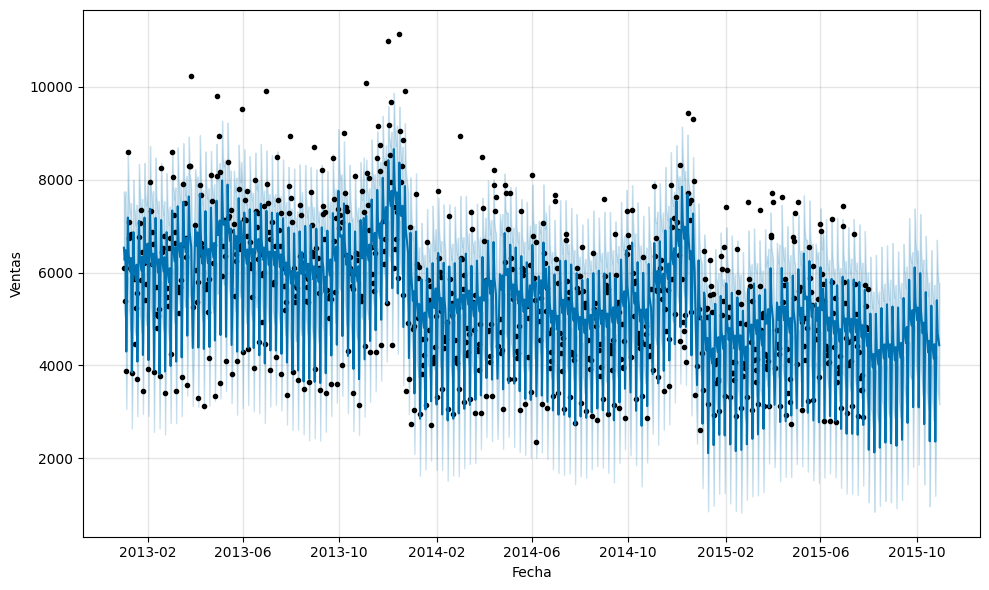

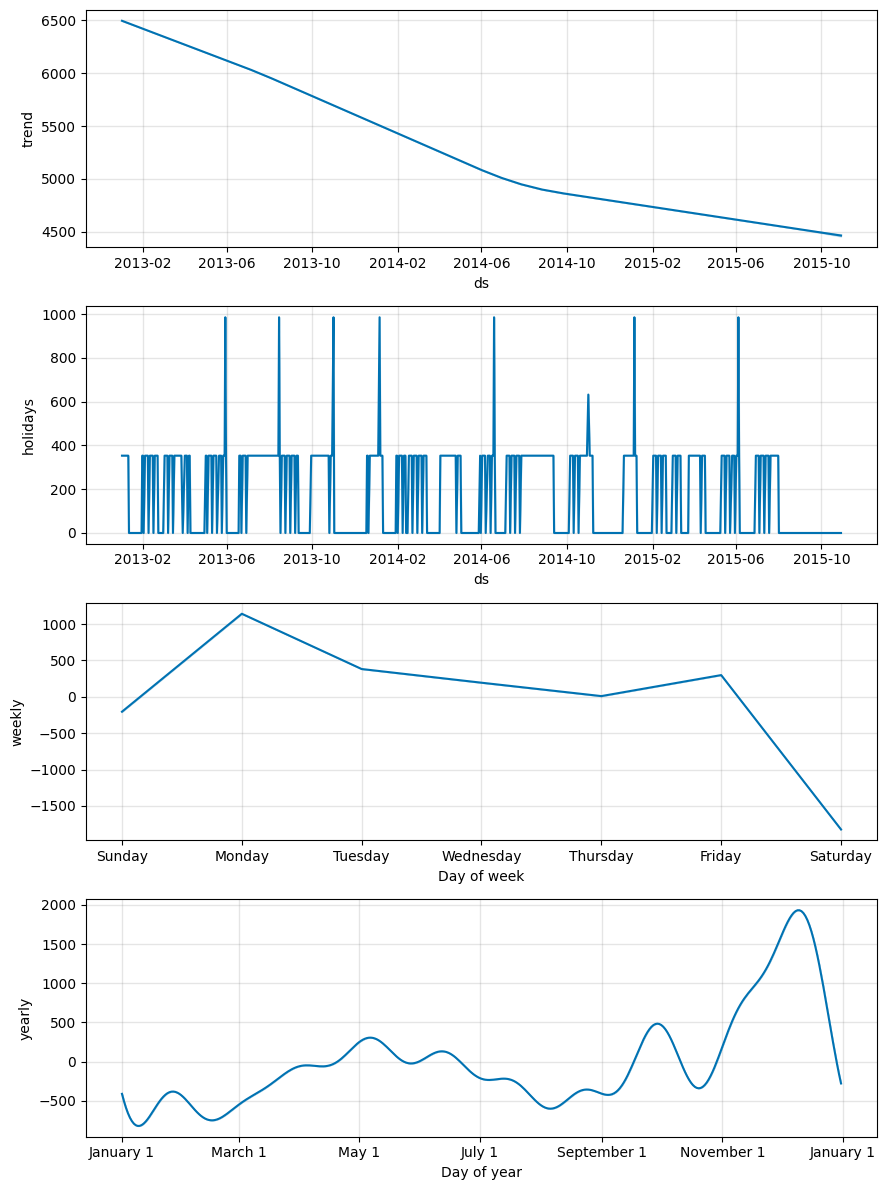

In [64]:
# Predicción usandon días festivos para una tienda específica
sales_predictions(6, sales_train_all_df, school_state_holidays, 90)